In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # Visualization
import seaborn as sns # For easier statistical plotting
sns.set_style("whitegrid")
from sklearn.model_selection import KFold, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # Preprocessing
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RANSACRegressor # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor  
from xgboost import XGBRegressor, plot_importance # XGBoost
from sklearn.svm import SVR  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.pipeline import Pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.base import clone # Clone estimator
from sklearn.metrics import mean_squared_error as MSE
from scipy import stats
import pickle
import shap
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import lime
import warnings
from pdpbox import pdp, get_dataset, info_plots
from time import time
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

<h3>Converting variables to required tyoes and fill na</h3>

In [7]:
df = pd.read_pickle('new_data_frame.pkl')
df = df.astype({'area_kitchen':float, 'price':float, 'area':float, 'area_rooms':float, 'area_kitchen':float,
               'subway':float, 'groceries':float, 'bar':float, 'school':float}, errors='ignore')
df['n_balcony'] = df['n_balcony'].fillna(0).astype(int)
df['n_lift'] = df['n_lift'].fillna(0).astype(int)

<h3>Imputing missing values using mean and mode</h3>

In [8]:
null_values_per_col = np.sum(df.drop(["price"], axis=1).isnull(), axis=0)
print(f'There are {np.sum(null_values_per_col != 0)} columns to impute.\n')

cols_to_impute = []
for col_index, val in null_values_per_col.items():
    if val != 0: cols_to_impute.append(col_index)

imputation_val_for_na_cols = dict()
for col in cols_to_impute:
    if (df[col].dtype == 'float64' ) or  (df[col].dtype == 'int64') or (df[col].dtype == 'int32'):
        imputation_val_for_na_cols[col] = np.nanmedian(df[col])
    else:
        imputation_val_for_na_cols[col] = df[col].value_counts().idxmax()

for key, val in imputation_val_for_na_cols.items():
    df[key].fillna(value= val, inplace = True)
    df[key].fillna(value = val, inplace = True)  

del imputation_val_for_na_cols, cols_to_impute

X, y = df.drop(['price', 'district', 'geo_district'], axis = 1), np.log(df["price"])
# X, y = df.drop(['price', 'district', 'geo_district'], axis = 1), df["price"]

There are 6 columns to impute.



<h3>Encoding categorical features</h3>

In [9]:
X.reset_index(drop=True, inplace=True)
categorical_features = []
is_categorical = X.dtypes == 'object'
for col in X.columns.tolist():
    if is_categorical[col]: categorical_features.append(col)
for feature in categorical_features:
    le = LabelEncoder()
    X[feature]  = le.fit_transform(X[feature])

In [10]:
seed = 7
test_split = 0.2
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size = test_split, random_state = seed)

<h3>Searching best model type</h3>

In [29]:
pipelines = []


pipelines.append(
                ("Scaled_Ridge", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Ridge", Ridge(random_state=seed))
                      ]))
                )

pipelines.append(
                ("Scaled_Lasso", 
                 Pipeline([
                     ("Scaler", StandardScaler()), 
                     ("Lasso", Lasso(random_state=seed))
                      ]))
                )
pipelines.append(
                ("Scaled_SVR",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("SVR", SVR())
                 ])
                )
                )

pipelines.append(
                ("Scaled_RF",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("RF", RandomForestRegressor(random_state=seed))
                 ])
                )
                )
pipelines.append(
                ("Scaled_ET",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("ET", ExtraTreesRegressor(random_state=seed))
                 ])
                )
                )
pipelines.append(
                ("Scaled_GBR",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", GradientBoostingRegressor(random_state=seed))
                 ])
                )
                )
pipelines.append(
                ("Scaled_BR",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("BR", BaggingRegressor(random_state=seed))
                 ])
                )
                )
pipelines.append(
                ("Scaled_XGB",
                 Pipeline([
                     ("Scaler", StandardScaler()),
                     ("XGB", XGBRegressor(seed=seed))
                 ])
                )
                )
scoring = 'r2'
n_folds = 10
results, names  = [], [] 

for name, model  in pipelines:
    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv= kfold,
                                 scoring=scoring, n_jobs=-1)    
    names.append(name)
    results.append(cv_results)    
    msg = f'{name}: {cv_results.mean()} (+/- {cv_results.std()})'
    print(msg)
    
results = pd.DataFrame(np.array(results).T, columns = names)    

Scaled_Ridge: 0.776853779670646 (+/- 0.012104440698974858)
Scaled_Lasso: -0.0008116208503048839 (+/- 0.0007864874703773058)
Scaled_SVR: 0.9189228453610143 (+/- 0.004632970883370685)
Scaled_RF: 0.9285871232280677 (+/- 0.003795522687175528)
Scaled_ET: 0.9303020574474825 (+/- 0.004535481200081753)
Scaled_GBR: 0.9163852692771606 (+/- 0.004782716575480684)
Scaled_BR: 0.928186967438473 (+/- 0.0043118902119837835)
Scaled_XGB: 0.9144874484695681 (+/- 0.004985747621789951)


<h3>Learning curve</h3<

In [7]:
model = XGBRegressor(max_depth=11, 
                    min_samples_leaf=2, 
                    max_features='auto',
                    n_estimators=150)
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=11, max_features='auto', min_child_weight=1,
       min_samples_leaf=2, missing=None, n_estimators=150, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

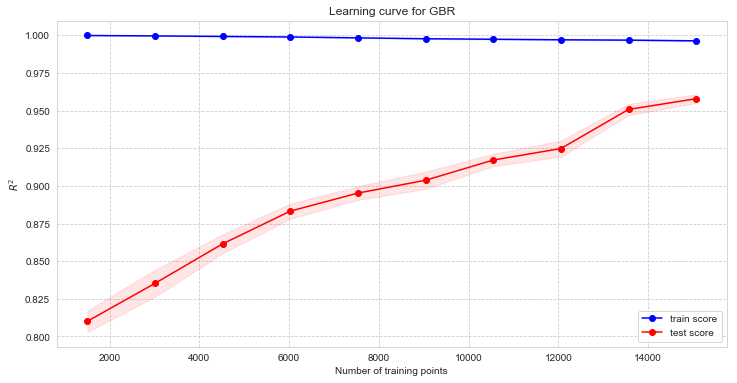

In [31]:
def plot_learning_curve(train_sizes, train_scores, test_scores, title, alpha=0.1):
    train_scores = train_scores
    test_scores = test_scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.plot(train_sizes, train_mean, label='train score', color='blue', marker='o')
    plt.fill_between(train_sizes,train_mean + train_std,
                    train_mean - train_std, color='blue', alpha=alpha)
    plt.plot(train_sizes, test_mean, label='test score', color='red',marker='o')
    plt.fill_between(train_sizes,test_mean + test_std, test_mean - test_std , color='red', alpha=alpha)
    plt.title(title)
    plt.xlabel('Number of training points')
    plt.ylabel(r'$R^2$')
    plt.grid(ls='--')
    plt.legend(loc='best')
    plt.show()     
    
model = XGBRegressor(max_depth=11, 
                   min_samples_leaf=2, 
                   max_features='auto',
                   n_estimators=150
                 )    
    
# Plot the learning curve
plt.figure(figsize=(12,6))
train_sizes, train_scores, test_scores = learning_curve(
                                            model , X=X, y=y, 
                                            cv=KFold(n_splits=10, shuffle=True, random_state=seed),
                                            scoring='r2',
                                            train_sizes=np.linspace(0.1, 1.0, 10)
                                            )

plot_learning_curve(train_sizes, train_scores, test_scores, title='Learning curve for GBR')

<h3>Grid search for best hyperparameters and regularization</h3>

In [30]:
Scaled_XGB = Pipeline([("Scaler", StandardScaler()),
                     ("XGB", XGBRegressor(random_state=seed, n_estimators=150))])

param_grid_et =  [{ 
        'XGB__min_samples_leaf': [2, 5, 10],
        'XGB__max_depth': range(1, 15, 1)
               }]

grid_rf = GridSearchCV(estimator=Scaled_XGB,
                               param_grid= param_grid_et,
                               scoring= 'r2',
                               cv = KFold(n_splits=3, random_state=seed, shuffle=True),
                               n_jobs = 4,
                               verbose = 10)
# Fit grid
grid_rf.fit(X, y)

# Best score and best parameters
print('-------Best score----------')
print(grid_rf.best_score_ )
print('-------Best params----------')
print(grid_rf.best_params_)

Fitting 3 folds for each of 42 candidates, totalling 126 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    4.1s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   10.5s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   17.2s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.3s
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:   38.4s
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:   54.6s
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done 126 out of 126 | elapsed:  4.0min finished


-------Best score----------
0.955105700511098
-------Best params----------
{'XGB__max_depth': 11, 'XGB__min_samples_leaf': 2}


<h3>Calibration results</h3>

In [29]:
scoring = 'r2'
n_folds = 3
results, msls, mds  = [], [], []
for msl in [2, 5, 10]:
    for md in range(1, 15, 1):
        model = Pipeline([("Scaler", StandardScaler()),
                     ("XGB", XGBRegressor(random_state=seed, n_estimators=150, max_depth=md, min_samples_leaf=msl))])
        kfold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv= kfold,
                                 scoring=scoring, n_jobs=4)    
        msls.append(msl)
        mds.append(md)
        results.append(f'{round(cv_results.mean(), 4)} (+/- {round(cv_results.std(), 4)}')    
pd.DataFrame([msls, mds, results]).T.to_excel('ghhh.xlsx', index=False, header=False)

<h3>Feature importance by permutation</h3>

In [14]:
perm = PermutationImportance(model, random_state=7).fit(X, y) #gonna us work properly
eli5.show_weights(perm, feature_names = [i for i in X])

Weight,Feature
0.8341 ± 0.0103,area
0.1105 ± 0.0013,bar
0.0577 ± 0.0007,dist_population
0.0234 ± 0.0004,n_floors
0.0230 ± 0.0007,eco_rating
0.0199 ± 0.0005,area_rooms
0.0178 ± 0.0003,repairs
0.0127 ± 0.0004,floor
0.0121 ± 0.0004,area_kitchen
0.0117 ± 0.0005,house_type


<h3>Feature importance by SHAP</h3>

In [14]:
shap_values = shap.TreeExplainer(model).shap_values(X.sample(n=2000, random_state=seed))
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X.sample(n=2000, random_state=seed))

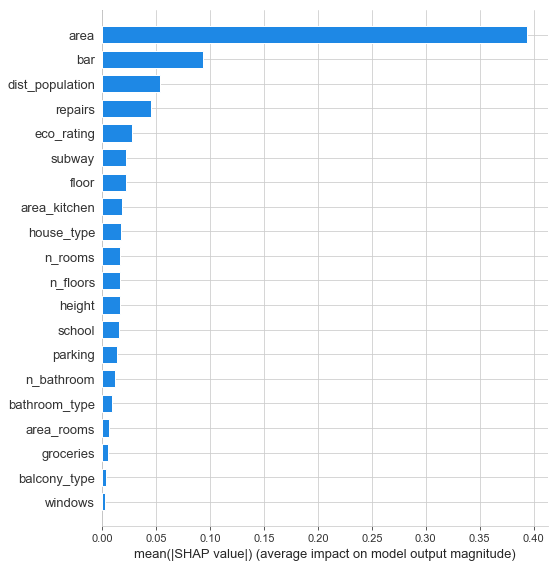

In [11]:
shap.summary_plot(shap_values, X, plot_type='bar')

<h3>Feature interaactions with SHAP</h3>

In [9]:
shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(X.sample(n=2000, random_state=seed))

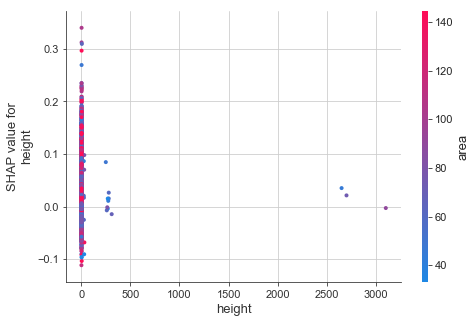

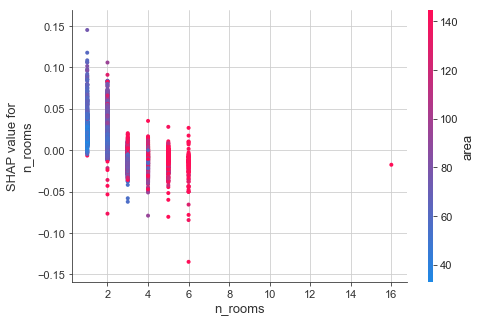

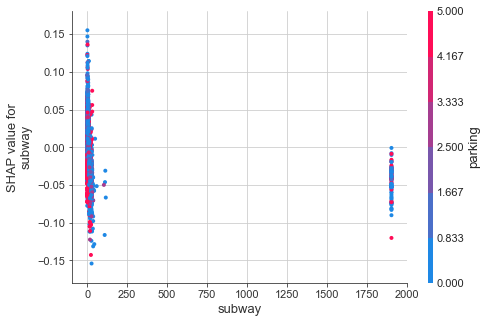

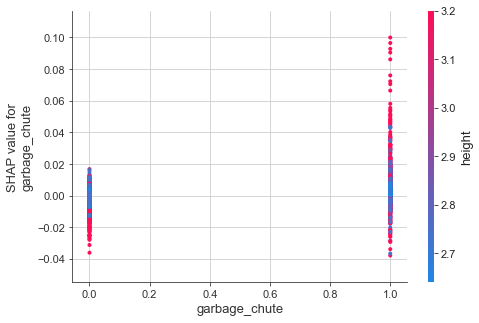

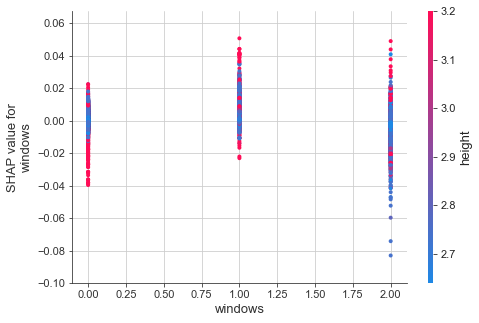

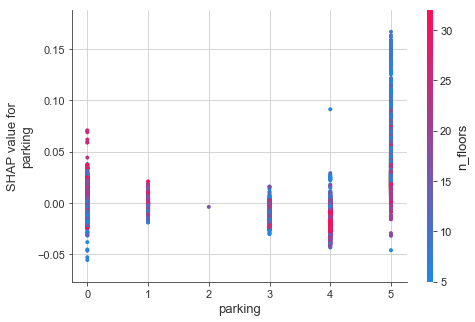

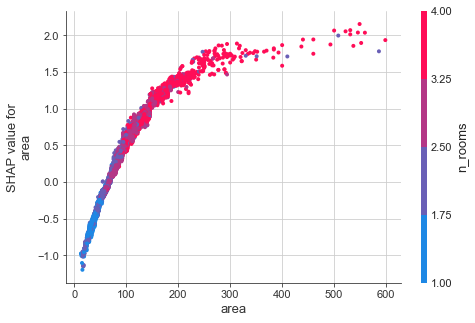

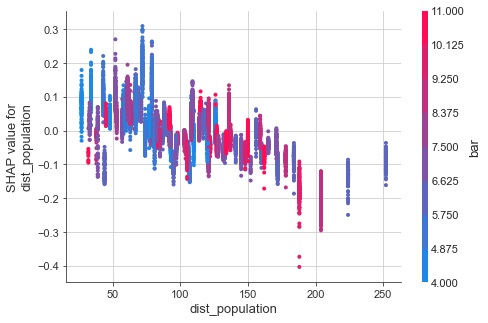

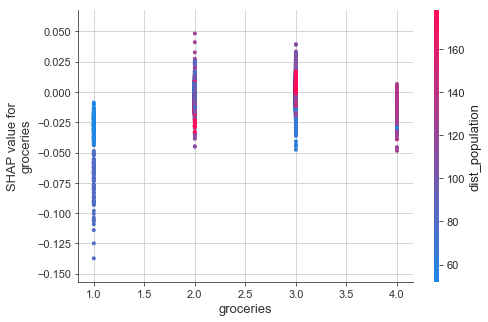

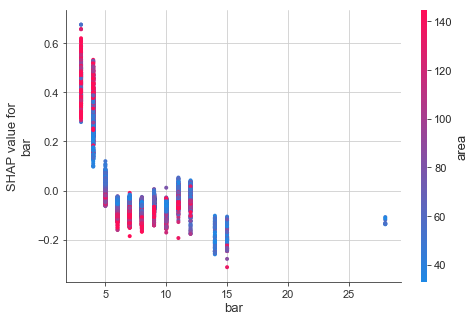

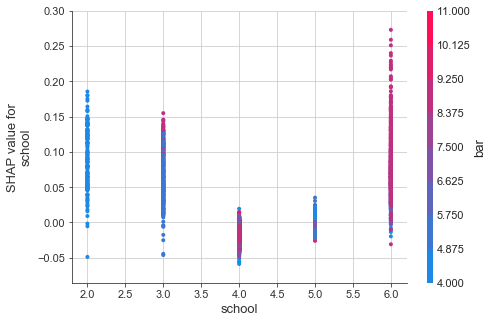

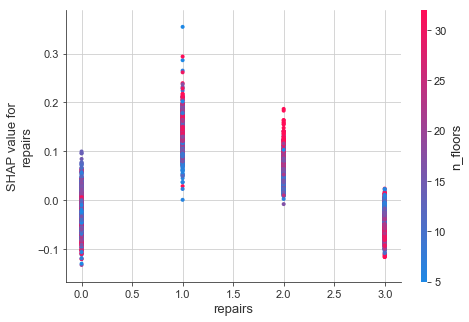

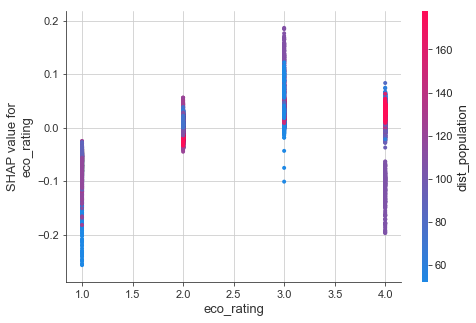

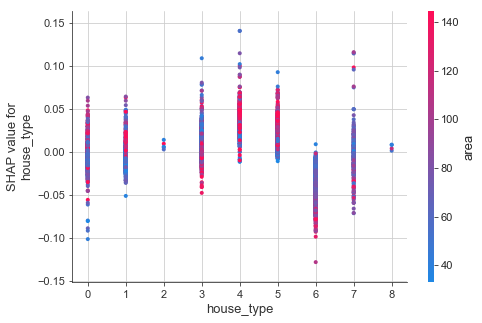

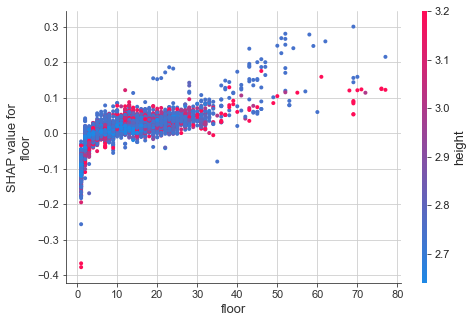

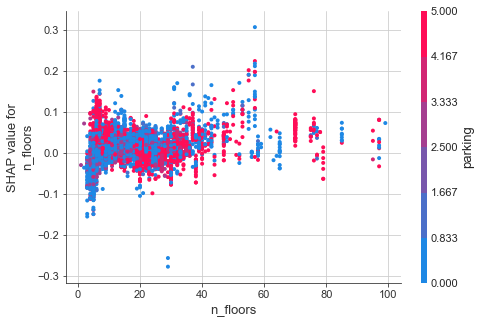

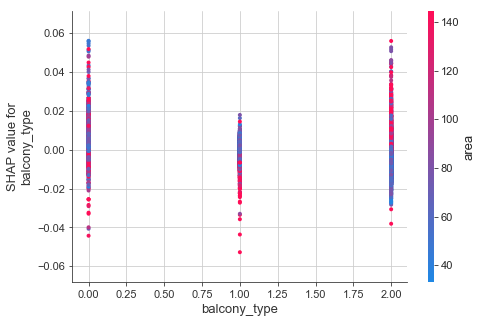

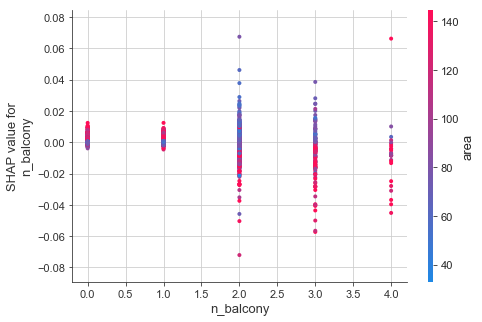

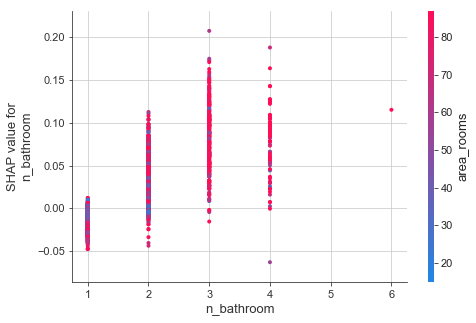

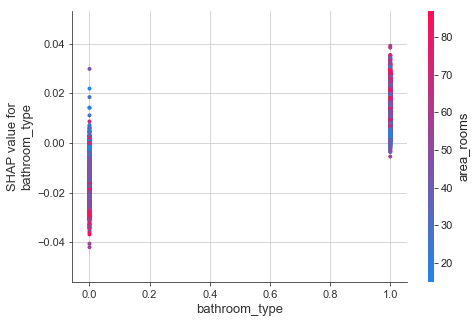

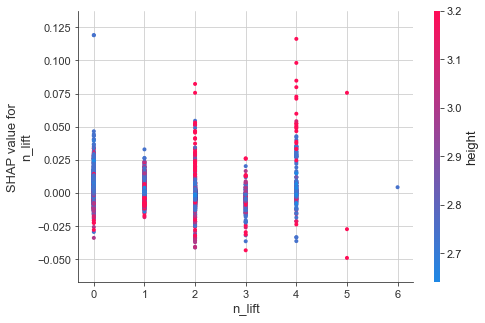

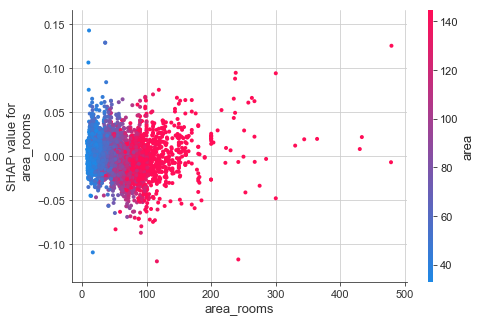

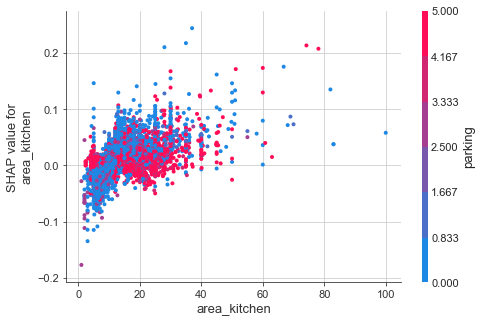

In [12]:
for col in X.columns:
    shap.dependence_plot(col, shap_values, X)

<h3>Local surrogate analysis for random observation</h3>

In [89]:
explainer_li = lime.lime_tabular.LimeTabularExplainer(X.astype(int).values, 
                                                   mode='regression',
                                                   training_labels=y,
                                                   feature_names=[i for i in X],
                                                     discretize_continuous=True)
i = 7
exp = explainer_li.explain_instance(X.iloc[i,:], model1.predict, num_features=15)
exp.show_in_notebook(show_table=True)